# Proyecto Redes Neuronales: Perceptrón Multicapa

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo de Perceptrón Multicapa (MLP) para clasificación de texto según el enunciado del proyecto.  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## Componentes implementados:
1. Configuración de Parámetros Globales
2. Carga y Preprocesamiento de Datos
3. Tokenización y Creación del Vocabulario
4. Construcción del Modelo MLP
5. Entrenamiento con Early Stopping
6. Evaluación del Modelo
7. Guardado de Resultados y Modelos
8. Visualización de Resultados
9. Historial de Experimentos

## 0. Configuración de Parámetros Globales

Esta sección permite modificar fácilmente todos los parámetros del modelo para experimentar.

In [1]:
# ===== CONFIGURACIÓN DE PARÁMETROS GLOBALES =====
# Esta sección centraliza todos los parámetros del modelo para facilitar experimentación

# Configuración general del experimento
EXPERIMENT_NAME = "MultiLayer_Perceptron (Embedding)"  # Nombre descriptivo del experimento
MODEL_TYPE = "MLP Embedding"  # Perceptrón Multi-Capa  
RANDOM_SEED = 42

# Directorios de trabajo
DATA_DIR = "data"
MODEL_DIR = "models"
OUTPUT_DIR = "output"

# Configuración del dataset - MEJORADO CON TÍTULO
TEXT_COLUMN = "review_body"  # Columna con el texto del cuerpo de la reseña
TITLE_COLUMN = "review_title"  # Columna con el título de la reseña
TARGET_COLUMN = "stars"  # Columna con las etiquetas (1-5 estrellas)
LANGUAGE_COLUMN = "language"  # Columna con el idioma
FILTER_LANGUAGE = "en"  # Filtrar por idioma específico. Opciones: None, "en", "es", "de", "fr", "ja"
USE_TITLE_AND_BODY = True  # NUEVO: Usar tanto título como cuerpo para mejor precisión
MAX_WORDS = 80000  # Tamaño máximo del vocabulario
MAX_LENGTH = 300  # Longitud máxima de las secuencias (aumentada por combinar título+cuerpo)
OOV_TOKEN = "<OOV>"  # Token para palabras fuera del vocabulario

# Parámetros de arquitectura del modelo - MLP
EMBEDDING_DIM = 300  # Dimensión del embedding de palabras
HIDDEN_LAYERS = [256, 128, 64]  # Lista con el número de neuronas en cada capa oculta
ACTIVATION = "relu"  # Función de activación para capas ocultas
OUTPUT_ACTIVATION = "softmax"  # Función de activación para la capa de salida
DROPOUT_RATE = 0.3  # Tasa de dropout para regularización

# Parámetros de entrenamiento
EPOCHS = 50  # Número máximo de épocas de entrenamiento
BATCH_SIZE = 512  # Tamaño del batch
LEARNING_RATE = 0.001  # Tasa de aprendizaje
PATIENCE = 10  # Paciencia para early stopping
OPTIMIZER = "adam"  # Optimizador a usar
LOSS_FUNCTION = "categorical_crossentropy"  # Función de pérdida
METRICS = ["accuracy"]  # Métricas a monitorear

print(f"=== Configuración del Experimento: {EXPERIMENT_NAME} ===")
print(f"Modelo: {MODEL_TYPE}")
print(f"Filtro de idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Usar título + cuerpo: {USE_TITLE_AND_BODY}")
print(f"Longitud máxima: {MAX_LENGTH} tokens")
print(f"Arquitectura oculta: {HIDDEN_LAYERS}")
print(f"Dimensión embedding: {EMBEDDING_DIM}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Épocas máximas: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Tasa de aprendizaje: {LEARNING_RATE}")
print("="*60)

=== Configuración del Experimento: MultiLayer_Perceptron (Embedding) ===
Modelo: MLP Embedding
Filtro de idioma: en
Usar título + cuerpo: True
Longitud máxima: 300 tokens
Arquitectura oculta: [256, 128, 64]
Dimensión embedding: 300
Dropout: 0.3
Épocas máximas: 50
Batch size: 512
Tasa de aprendizaje: 0.001


## 1. Importación de Librerías y Funciones Helper

In [ ]:
# ===== IMPORTAR LIBRERÍAS Y MÓDULOS =====
import os
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Importar funciones helper
from helper import (
    DataLoader, ModelTrainer, ResultsManager, Visualizer,
    evaluate_model, setup_experiment_environment
)

# Configurar ambiente del experimento
gpu_info = setup_experiment_environment(RANDOM_SEED)
print(f"Ambiente configurado. GPU disponible: {gpu_info['gpu_available']}")

2025-09-29 00:11:12.901126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 00:11:12.940325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-29 00:11:13.842516: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU configurada: 1 GPU(s) disponibles
Ambiente configurado. GPU disponible: True


## 2. Carga y Preprocesamiento de Datos

In [3]:
# Inicializar el cargador de datos
data_loader = DataLoader(data_dir=DATA_DIR)

# Cargar los datasets
print("Cargando datasets...")
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nDatos originales cargados:")
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Validación: {len(val_df)} muestras") 
print(f"Prueba: {len(test_df)} muestras")

# Verificar que las columnas necesarias existen
required_columns = [TEXT_COLUMN, TARGET_COLUMN, LANGUAGE_COLUMN]
if USE_TITLE_AND_BODY:
    required_columns.append(TITLE_COLUMN)

missing_columns = [col for col in required_columns if col not in train_df.columns]
if missing_columns:
    print(f"Columnas faltantes: {missing_columns}")
    print(f"Columnas disponibles: {list(train_df.columns)}")
else:
    print(f"Todas las columnas requeridas están disponibles")
    if USE_TITLE_AND_BODY:
        print(f"Modo combinado: {TITLE_COLUMN} + {TEXT_COLUMN}")

# Analizar distribución de idiomas
print(f"\nAnálisis de idiomas en el dataset:")
if LANGUAGE_COLUMN in train_df.columns:
    lang_dist_train = train_df[LANGUAGE_COLUMN].value_counts()
    print(f"Distribución de idiomas (entrenamiento):")
    for lang, count in lang_dist_train.items():
        percentage = (count / len(train_df)) * 100
        print(f"  {lang}: {count:,} muestras ({percentage:.1f}%)")
    
    # Aplicar filtro por idioma si está especificado
    if FILTER_LANGUAGE is not None:
        if FILTER_LANGUAGE in lang_dist_train.index:
            print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
            
            # Filtrar datasets por idioma
            train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            
            print(f"\nDatos después del filtrado por idioma '{FILTER_LANGUAGE}':")
            print(f"Entrenamiento: {len(train_df)} muestras")
            print(f"Validación: {len(val_df)} muestras")
            print(f"Prueba: {len(test_df)} muestras")
        else:
            print(f"\nAdvertencia: Idioma '{FILTER_LANGUAGE}' no encontrado en el dataset.")
            print(f"Idiomas disponibles: {list(lang_dist_train.index)}")
            print("Usando todos los idiomas...")
    else:
        print(f"\nUsando todos los idiomas disponibles")
else:
    print(f"Columna '{LANGUAGE_COLUMN}' no encontrada. Usando todos los datos sin filtrar.")

# Mostrar distribución de clases en el conjunto final
print(f"\nDistribución de clases (conjunto final):")
class_distribution = train_df[TARGET_COLUMN].value_counts().sort_index()
for stars, count in class_distribution.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {stars} estrella(s): {count:,} muestras ({percentage:.1f}%)")

# Mostrar ejemplos de datos con título y cuerpo
print(f"\nEjemplos de datos del conjunto final:")
for i in range(min(3, len(train_df))):
    lang = train_df[LANGUAGE_COLUMN].iloc[i] if LANGUAGE_COLUMN in train_df.columns else "N/A"
    title = train_df[TITLE_COLUMN].iloc[i] if USE_TITLE_AND_BODY and TITLE_COLUMN in train_df.columns else "N/A"
    text = train_df[TEXT_COLUMN].iloc[i][:80]  # Menos texto para mostrar título también
    stars = train_df[TARGET_COLUMN].iloc[i]
    
    print(f"{i+1}. [{lang}] {stars} estrella(s)")
    if USE_TITLE_AND_BODY and title != "N/A":
        print(f"   Título: {title[:60]}{'...' if len(str(title)) > 60 else ''}")
    print(f"   Cuerpo: {text}{'...' if len(str(train_df[TEXT_COLUMN].iloc[i])) > 80 else ''}")
    print()

Cargando datasets...
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales cargados:
Entrenamiento: 1200000 muestras
Validación: 30000 muestras
Prueba: 30000 muestras
Todas las columnas requeridas están disponibles
Modo combinado: review_title + review_body

Análisis de idiomas en el dataset:
Distribución de idiomas (entrenamiento):
  de: 200,000 muestras (16.7%)
  en: 200,000 muestras (16.7%)
  es: 200,000 muestras (16.7%)
  fr: 200,000 muestras (16.7%)
  ja: 200,000 muestras (16.7%)
  zh: 200,000 muestras (16.7%)

Filtrando por idioma: en

Datos después del filtrado por idioma 'en':
Entrenamiento: 200000 muestras
Validación: 5000 muestras
Prueba: 5000 muestras

Distribución de clases (conjunto final):
  1 estrella(s): 40,000 muestras (20.0%)
  2 estrella(s): 40,000 muestras (20.0%)
  3 estrella(s): 40,000 muestras (20.0%)
  4 estrella(s): 40,000 muestras (20.0%)
  5 estrella(s): 40,000 muestras (20.0

### Configuraciones Rápidas por Idioma

Para cambiar el idioma del experimento, modifica la variable `FILTER_LANGUAGE` en la primera celda:

```python
# Opciones disponibles:
FILTER_LANGUAGE = None     # Todos los idiomas (por defecto)
FILTER_LANGUAGE = "en"     # Solo inglés 
FILTER_LANGUAGE = "es"     # Solo español
FILTER_LANGUAGE = "de"     # Solo alemán
FILTER_LANGUAGE = "fr"     # Solo francés
FILTER_LANGUAGE = "ja"     # Solo japonés
```

**Recomendaciones:**
- **`"en"` (Inglés)**: Mayor cantidad de datos, vocabulario más rico
- **`"es"` (Español)**: Bueno para comparar rendimiento en español
- **`None` (Todos)**: Para experimentos multiidioma
- **Otros idiomas**: Para análisis específicos por idioma

In [4]:
# CONFIGURACIÓN RÁPIDA - Descomenta una línea para cambiar idioma
# FILTER_LANGUAGE = None      # Por defecto: todos los idiomas
# FILTER_LANGUAGE = "en"      # Solo inglés (recomendado para mejor rendimiento)
# FILTER_LANGUAGE = "es"      # Solo español 
# FILTER_LANGUAGE = "de"      # Solo alemán
# FILTER_LANGUAGE = "fr"      # Solo francés
# FILTER_LANGUAGE = "ja"      # Solo japonés

# Si cambias el idioma aquí, ejecuta esta celda y vuelve a ejecutar desde la carga de datos
print(f"Configuración actual: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Todos los idiomas'}")
print("Tip: Para inglés únicamente (mejor rendimiento), descomenta: FILTER_LANGUAGE = 'en'")

Configuración actual: en
Tip: Para inglés únicamente (mejor rendimiento), descomenta: FILTER_LANGUAGE = 'en'


## 3. Preprocesamiento de Texto

In [5]:
# Preprocesar los datos de texto
print("Preprocesando datos de texto...")
print(f"Modo: {'Título + Cuerpo' if USE_TITLE_AND_BODY else 'Solo Cuerpo'}")

processed_data = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df, 
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_WORDS,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY
)

# Extraer datos preprocesados
X_train, y_train = processed_data['X_train'], processed_data['y_train']
X_val, y_val = processed_data['X_val'], processed_data['y_val']
X_test, y_test = processed_data['X_test'], processed_data['y_test']
num_classes = processed_data['num_classes']
vocab_size = processed_data['vocab_size']

print(f"\nDatos preprocesados:")
print(f"Tamaño del vocabulario: {vocab_size}")
print(f"Número de clases: {num_classes}")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Texto combinado: {'Sí (título + cuerpo)' if USE_TITLE_AND_BODY else 'No (solo cuerpo)'}")

# Obtener nombres de clases para evaluación
class_names = [str(i) for i in data_loader.label_encoder.classes_]

Preprocesando datos de texto...
Modo: Título + Cuerpo
Preprocesando datos de texto...
Tamaño del vocabulario: 49069
Número de clases: 5
Longitud de secuencia: 300
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Datos preprocesados:
Tamaño del vocabulario: 49070
Número de clases: 5
Forma de X_train: (200000, 300)
Forma de y_train: (200000, 5)
Texto combinado: Sí (título + cuerpo)


### Mejora Implementada: Título + Cuerpo

**Ventajas de combinar título y cuerpo:**
- **Más contexto:** El título often contiene información clave sobre el sentiment
- **Mejor precisión:** Más información textual para el modelo
- **Vocabulario enriquecido:** Palabras clave del título complementan el cuerpo

In [6]:
# Veamos algunos ejemplos de cómo se ve el texto combinado
print("EJEMPLOS DE TEXTO COMBINADO (Título + Cuerpo):")
print("=" * 60)

# Seleccionar algunos ejemplos del conjunto de entrenamiento
for i in range(3):
    title = train_df.iloc[i]['review_title']
    body = train_df.iloc[i]['review_body']
    combined = f"{title} {body}"
    stars = train_df.iloc[i]['stars']
    
    print(f"\nEjemplo {i+1} - {stars} estrella(s):")
    print(f"Título: {title}")
    print(f"Cuerpo: {body[:100]}...")
    print(f"Combinado: {combined[:150]}...")
    print("-" * 40)

print(f"\nBeneficios de la combinación:")
print(f"   Mayor contexto semántico")
print(f"   Información clave del título se preserva")  
print(f"   Vocabulario más rico para el modelo")
print(f"   Longitud máxima aumentada a {MAX_LENGTH} tokens")

EJEMPLOS DE TEXTO COMBINADO (Título + Cuerpo):

Ejemplo 1 - 1 estrella(s):
Título: I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...
Cuerpo: Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so ther...
Combinado: I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ... Arrived broken. Manufacturer defect. T...
----------------------------------------

Ejemplo 2 - 1 estrella(s):
Título: Not use able
Cuerpo: the cabinet dot were all detached from backing... got me...
Combinado: Not use able the cabinet dot were all detached from backing... got me...
----------------------------------------

Ejemplo 3 - 1 estrella(s):
Título: The product is junk.
Cuerpo: I received my first order of this product and it was broke so I ordered it again. The second one was...
Combinado: The product is junk. I received my first order of this product an

### Función para Comparar Configuraciones

Esta celda permite cambiar fácilmente entre usar solo el cuerpo o título+cuerpo:

In [7]:
# CONFIGURACIÓN RÁPIDA - Cambia aquí para experimentar
print("CONFIGURACIONES DISPONIBLES:")
print("=" * 50)
print("1. Título + Cuerpo (ACTUAL)")
print("   - USE_TITLE_AND_BODY = True")
print("   - MAX_LENGTH = 300")
print("   - Mejor precisión esperada")
print()
print("2. Solo Cuerpo (TRADICIONAL)") 
print("   - USE_TITLE_AND_BODY = False")
print("   - MAX_LENGTH = 250")
print("   - Más rápido de procesar")
print()
print(f"Configuración actual: {'Título + Cuerpo' if USE_TITLE_AND_BODY else 'Solo Cuerpo'}")
print(f"Longitud máxima: {MAX_LENGTH} tokens")
print(f"Vocabulario: {vocab_size:,} palabras")
print()
print("Para cambiar configuración:")
print("   1. Modifica USE_TITLE_AND_BODY en la primera celda")
print("   2. Ajusta MAX_LENGTH según necesites")
print("   3. Re-ejecuta desde la carga de datos")

CONFIGURACIONES DISPONIBLES:
1. Título + Cuerpo (ACTUAL)
   - USE_TITLE_AND_BODY = True
   - MAX_LENGTH = 300
   - Mejor precisión esperada

2. Solo Cuerpo (TRADICIONAL)
   - USE_TITLE_AND_BODY = False
   - MAX_LENGTH = 250
   - Más rápido de procesar

Configuración actual: Título + Cuerpo
Longitud máxima: 300 tokens
Vocabulario: 49,070 palabras

Para cambiar configuración:
   1. Modifica USE_TITLE_AND_BODY en la primera celda
   2. Ajusta MAX_LENGTH según necesites
   3. Re-ejecuta desde la carga de datos


## 4. Construcción del Modelo MLP

In [8]:
def create_mlp_model(vocab_size, embedding_dim, max_length, hidden_layers, 
                     num_classes, dropout_rate, activation, output_activation):
    """
    Crear un modelo de Perceptrón Multicapa para clasificación de texto.
    
    Args:
        vocab_size: Tamaño del vocabulario
        embedding_dim: Dimensión del embedding
        max_length: Longitud máxima de secuencia
        hidden_layers: Lista con el número de neuronas en cada capa oculta
        num_classes: Número de clases de salida
        dropout_rate: Tasa de dropout
        activation: Función de activación para capas ocultas
        output_activation: Función de activación para la capa de salida
    
    Returns:
        tf.keras.Model: Modelo compilado
    """
    model = Sequential()
    
    # Capa de embedding (sin input_length que está deprecado)
    model.add(Embedding(input_dim=vocab_size, 
                       output_dim=embedding_dim,
                       name="embedding_layer"))
    
    # Pooling global para reducir dimensionalidad
    model.add(GlobalAveragePooling1D(name="global_avg_pooling"))
    
    # Capas ocultas del MLP
    for i, units in enumerate(hidden_layers):
        model.add(Dense(units=units, 
                       activation=activation, 
                       name=f"dense_layer_{i+1}"))
        model.add(Dropout(rate=dropout_rate, 
                         name=f"dropout_{i+1}"))
    
    # Capa de salida
    model.add(Dense(units=num_classes, 
                   activation=output_activation, 
                   name="output_layer"))
    
    return model

# Crear el modelo
print("Creando modelo MLP...")
model = create_mlp_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_LENGTH,
    hidden_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    activation=ACTIVATION,
    output_activation=OUTPUT_ACTIVATION
)

# Compilar el modelo
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=LOSS_FUNCTION,
    metrics=METRICS
)

# Construir el modelo con la forma de entrada específica
model.build(input_shape=(None, MAX_LENGTH))

# Mostrar arquitectura del modelo
print("\nArquitectura del modelo:")
model.summary()

# Contar parámetros
total_params = model.count_params()
print(f"\nTotal de parámetros: {total_params:,}")

Creando modelo MLP...


I0000 00:00:1759122685.863868  151591 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9293 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 300, 300)       │    14,721,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,533 (56.61 MB)

 Trainable params: 14,839,533 (56.61 MB)

 Non-trainable params: 0 (0.00 B)


Total de parámetros: 14,839,533


## 5. Entrenamiento del Modelo

In [9]:
# Inicializar el entrenador de modelos
model_trainer = ModelTrainer(model_dir=MODEL_DIR)

# Entrenar el modelo
print("Iniciando entrenamiento...")
training_results = model_trainer.train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE,
    model_name=f"{MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
)

print(f"\nEntrenamiento completado:")
print(f"Épocas entrenadas: {training_results['epochs_trained']}")
print(f"Tiempo de entrenamiento: {training_results['training_time']:.1f} segundos")
print(f"Accuracy final (entrenamiento): {training_results['final_train_accuracy']:.4f}")
print(f"Accuracy final (validación): {training_results['final_val_accuracy']:.4f}")

Iniciando entrenamiento...
Entrenando MLP Embedding_20250929_001126...
Parámetros del modelo: 14,839,533
✅ Convertidas a float32 para mejor rendimiento
✅ Forma de entrada: (200000, 300)
✅ Tipo de datos: float32
Epoch 1/50


2025-09-29 00:11:27.292306: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f6d78016460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-29 00:11:27.292324: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-29 00:11:27.313795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-29 00:11:27.447491: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-29 00:11:27.557647: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:11:27.557716: I e

  7/391 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.1970 - loss: 1.6101

I0000 00:00:1759122690.868297  151704 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2114 - loss: 1.6079

2025-09-29 00:11:39.140912: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:11:39.140962: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:11:39.884525: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1599', 4 bytes spill stores, 4 bytes spill loads

2025-09-29 00:11:40.480801: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2115 - loss: 1.6078

2025-09-29 00:11:42.124033: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:11:42.754909: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 116 bytes spill stores, 116 bytes spill loads

2025-09-29 00:11:43.309373: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:11:43.717912: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.2238 - loss: 1.6056 - val_accuracy: 0.2004 - val_loss: 1.6099 - learning_rate: 0.0010
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2277 - loss: 1.5970 - val_accuracy: 0.1994 - val_loss: 1.6092 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2528 - loss: 1.5762 - val_accuracy: 0.3140 - val_loss: 1.4956 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3588 - loss: 1.3888 - val_accuracy: 0.3978 - val_loss: 1.3324 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4399 - loss: 1.2306 - val_accuracy: 0.4602 - val_loss: 1.1655 - learning_rate: 0.0010
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5045 - loss: 1.1292 - val_accuracy: 0.5288 - val_loss: 1.0663 - learning_rate: 0.0010
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5394 - loss: 1.0698 - val

Modelo guardado en: models/MLP Embedding_20250929_001126.h5

Entrenamiento completado:
Épocas entrenadas: 27
Tiempo de entrenamiento: 228.4 segundos
Accuracy final (entrenamiento): 0.6393
Accuracy final (validación): 0.5832


## 6. Visualización del Entrenamiento

Gráfico de historial de entrenamiento guardado en: output/MLP Embedding_training_history.png


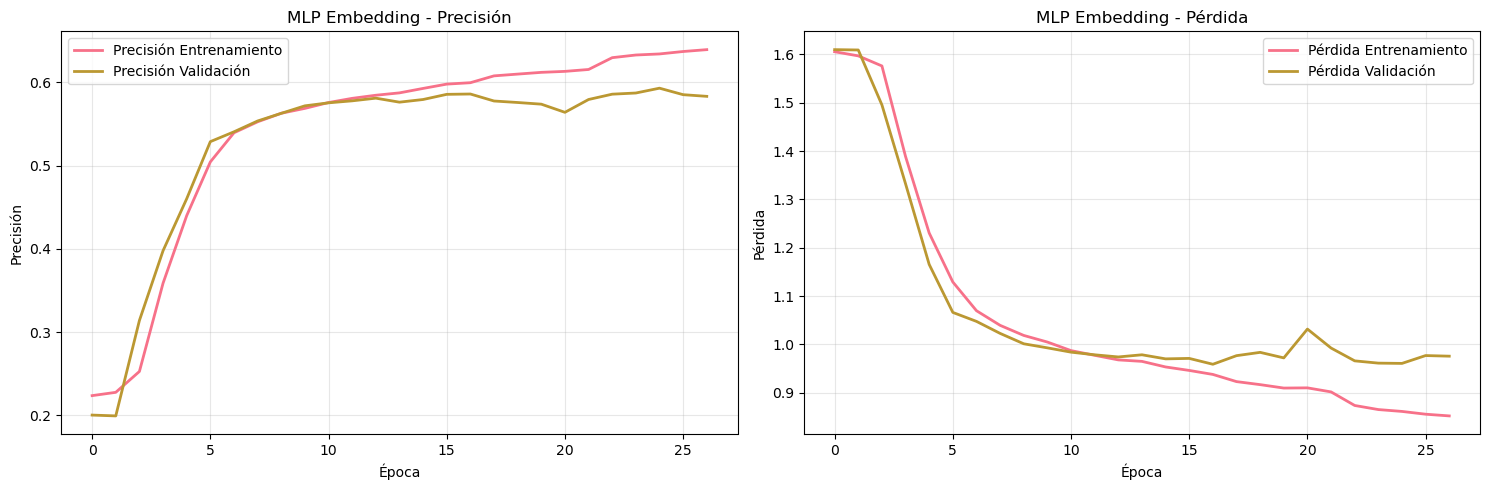

In [10]:
# Visualizar el historial de entrenamiento
Visualizer.plot_training_history(
    history=training_results['history'],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_training_history.png")
)

## 7. Evaluación del Modelo

In [11]:
# Evaluar el modelo en el conjunto de prueba
evaluation_results = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    class_names=class_names
)

# Extraer métricas de evaluación
test_accuracy = evaluation_results['test_accuracy']
test_loss = evaluation_results['test_loss']
classification_rep = evaluation_results['classification_report']
y_true = evaluation_results['y_true']
y_pred = evaluation_results['y_pred']

print(f"\nResultados en conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print(f"F1-Score (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"F1-Score (weighted): {classification_rep['weighted avg']['f1-score']:.4f}")

Evaluando modelo en datos de prueba...


2025-09-29 00:15:15.533505: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:15:15.533527: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:15:15.978571: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads

2025-09-29 00:15:16.690058: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

102/157 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step

2025-09-29 00:15:17.623232: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads



157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Precisión de Prueba: 0.5880
Pérdida de Prueba: 0.9611

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.66      0.74      0.70      1000
           2       0.49      0.51      0.50      1000
           3       0.48      0.41      0.45      1000
           4       0.57      0.49      0.53      1000
           5       0.71      0.78      0.74      1000

    accuracy                           0.59      5000
   macro avg       0.58      0.59      0.58      5000
weighted avg       0.58      0.59      0.58      5000


Resultados en conjunto de prueba:
Accuracy: 0.5880
Loss: 0.9611
F1-Score (macro): 0.5829
F1-Score (weighted): 0.5829


## 8. Matriz de Confusión

Matriz de confusión guardada en: output/MLP Embedding_confusion_matrix.png


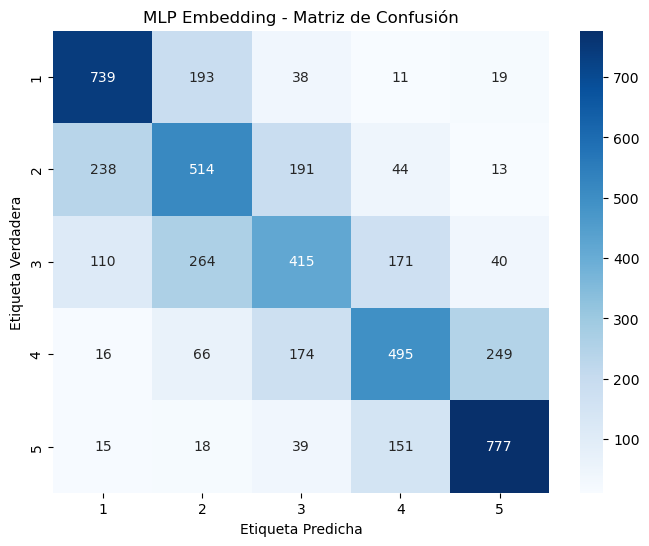

In [12]:
# Visualizar matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_confusion_matrix.png")
)

## 9. Guardado de Resultados del Experimento

In [13]:
# Preparar datos del experimento para guardar
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'text_column': TEXT_COLUMN,
        'target_column': TARGET_COLUMN,
        'language_filter': FILTER_LANGUAGE,  # ← Nueva información de idioma
        'max_words': MAX_WORDS,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_layers': HIDDEN_LAYERS,
        'activation': ACTIVATION,
        'output_activation': OUTPUT_ACTIVATION,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'patience': PATIENCE,
        'optimizer': OPTIMIZER,
        'loss_function': LOSS_FUNCTION,
        'random_seed': RANDOM_SEED,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'class_distribution': class_distribution.to_dict(),
        'language_used': FILTER_LANGUAGE if FILTER_LANGUAGE else "multilingual"  # ← Nueva información
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'precision_macro': classification_rep['macro avg']['precision'],
        'recall_macro': classification_rep['macro avg']['recall'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar resultados del experimento
results_manager = ResultsManager(output_dir=OUTPUT_DIR)
experiment_id = results_manager.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado exitosamente.")
print(f"Idioma utilizado: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Modelo guardado en: {training_results['model_path']}")
print(f"Resultados guardados en: {OUTPUT_DIR}/experiment_history.json")

Experiment 2 results saved to output/experiment_history.json

Experimento #2 guardado exitosamente.
Idioma utilizado: en
Modelo guardado en: models/MLP Embedding_20250929_001126.h5
Resultados guardados en: output/experiment_history.json


## 10. Resumen del Experimento

In [14]:
# Mostrar resumen del experimento actual
print(f"RESUMEN DEL EXPERIMENTO #{experiment_id}")
print("=" * 60)
print(f"Modelo: {MODEL_TYPE}")
print(f"Idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma (todos)'}")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print(f"Parámetros totales: {total_params:,}")
print(f"")
print(f"Dataset:")
print(f"  - Entrenamiento: {len(train_df):,} muestras")
print(f"  - Validación: {len(val_df):,} muestras")
print(f"  - Prueba: {len(test_df):,} muestras")
print(f"")
print(f"Entrenamiento:")
print(f"  - Épocas: {training_results['epochs_trained']}/{EPOCHS}")
print(f"  - Tiempo: {training_results['training_time']:.1f}s")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"")
print(f"Resultados:")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - F1-Score (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"  - F1-Score (weighted): {classification_rep['weighted avg']['f1-score']:.4f}")
print(f"")
print(f"Hardware: {'GPU' if gpu_info['gpu_available'] else 'CPU'}")

# Mostrar distribución de clases final
print(f"")
print(f"Distribución de clases utilizadas:")
for stars, count in class_distribution.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {stars} estrella(s): {count:,} ({percentage:.1f}%)")

RESUMEN DEL EXPERIMENTO #2
Modelo: MLP Embedding
Idioma: en
Arquitectura: [256, 128, 64]
Parámetros totales: 14,839,533

Dataset:
  - Entrenamiento: 200,000 muestras
  - Validación: 5,000 muestras
  - Prueba: 5,000 muestras

Entrenamiento:
  - Épocas: 27/50
  - Tiempo: 228.4s
  - Batch size: 512
  - Learning rate: 0.001

Resultados:
  - Test Accuracy: 0.5880
  - Test Loss: 0.9611
  - F1-Score (macro): 0.5829
  - F1-Score (weighted): 0.5829

Hardware: GPU

Distribución de clases utilizadas:
  1 estrella(s): 40,000 (20.0%)
  2 estrella(s): 40,000 (20.0%)
  3 estrella(s): 40,000 (20.0%)
  4 estrella(s): 40,000 (20.0%)
  5 estrella(s): 40,000 (20.0%)


## 11. Historial de Experimentos

In [15]:
# Mostrar historial completo de experimentos
results_manager.display_experiment_history()


HISTORIAL DE EXPERIMENTOS (2 experimentos)

ID  Modelo       Lang   Precisión  Pérdida    Épocas   Tiempo (s) Muestras  
-----------------------------------------------------------------------------------------------
1   MLP_BoW      en     0.4916     1.8420     12       34.4       200,000   
2   MLP Embeddi  en     0.5832     0.9758     27       228.4      200,000   

BEST EXPERIMENTS BY LANGUAGE:
--------------------------------------------------
en    : ID #2 - Accuracy: 0.5832 (200,000 samples)

OVERALL BEST: ID #2 (en) - Accuracy: 0.5832


## 12. Predicciones de Ejemplo

In [16]:
def predict_sample_texts(model, tokenizer, sample_texts, class_names, max_length):
    """
    Hacer predicciones en textos de ejemplo.
    
    Args:
        model: Modelo entrenado
        tokenizer: Tokenizer usado para entrenar
        sample_texts: Lista de textos de ejemplo
        class_names: Nombres de las clases
        max_length: Longitud máxima de secuencia
    """
    # Procesar textos
    sequences = tokenizer.texts_to_sequences(sample_texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=max_length, padding='post', truncating='post'
    )
    
    # Hacer predicciones
    predictions = model.predict(padded)
    predicted_classes = np.argmax(predictions, axis=1)
    
    print("PREDICCIONES DE EJEMPLO:")
    print("=" * 60)
    
    for i, text in enumerate(sample_texts):
        pred_class = predicted_classes[i]
        confidence = predictions[i][pred_class]
        
        print(f"Texto: {text[:100]}...")
        print(f"Predicción: {class_names[pred_class]} estrellas (confianza: {confidence:.3f})")
        print("-" * 40)

# Ejemplos de textos para probar - MEJORADOS CON TÍTULOS
if USE_TITLE_AND_BODY:
    sample_texts = [
        "Excelente producto Este producto es excelente, muy buena calidad y llegó rápido",
        "Producto terrible Terrible producto, no funciona como se describe", 
        "Producto normal El producto está bien, cumple con lo básico",
        "Producto increíble Increíble calidad, superó mis expectativas completamente",
        "No recomendado No recomiendo este producto, muy mala experiencia"
    ]
    print("Usando formato: [TÍTULO] + [CUERPO] para mejores predicciones")
else:
    sample_texts = [
        "Este producto es excelente, muy buena calidad y llegó rápido",
        "Terrible producto, no funciona como se describe", 
        "El producto está bien, cumple con lo básico",
        "Increíble calidad, superó mis expectativas completamente",
        "No recomiendo este producto, muy mala experiencia"
    ]
    print("Usando formato: solo [CUERPO]")

# Hacer predicciones en ejemplos
predict_sample_texts(
    model=model,
    tokenizer=data_loader.tokenizer,
    sample_texts=sample_texts,
    class_names=class_names,
    max_length=MAX_LENGTH
)

Usando formato: [TÍTULO] + [CUERPO] para mejores predicciones


2025-09-29 00:15:19.930623: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
PREDICCIONES DE EJEMPLO:
Texto: Excelente producto Este producto es excelente, muy buena calidad y llegó rápido...
Predicción: 5 estrellas (confianza: 0.220)
----------------------------------------
Texto: Producto terrible Terrible producto, no funciona como se describe...
Predicción: 1 estrellas (confianza: 0.886)
----------------------------------------
Texto: Producto normal El producto está bien, cumple con lo básico...
Predicción: 2 estrellas (confianza: 0.340)
----------------------------------------
Texto: Producto increíble Increíble calidad, superó mis expectativas completamente...
Predicción: 2 estrellas (confianza: 0.247)
----------------------------------------
Texto: No recomendado No recomiendo este producto, muy mala experiencia...
Predicción: 1 estrellas (confianza: 0.438)
----------------------------------------


## 13. Análisis de Errores

In [17]:
# Analizar algunos errores del modelo
def analyze_errors(X_test, y_test, y_pred, test_df, text_column, target_column, n_examples=5):
    """
    Analizar ejemplos donde el modelo se equivocó.
    """
    # Encontrar índices donde el modelo se equivocó
    y_test_labels = np.argmax(y_test, axis=1)
    error_indices = np.where(y_test_labels != y_pred)[0]
    
    if len(error_indices) == 0:
        print("Perfecto. El modelo no cometió errores en el conjunto de prueba.")
        return
    
    print(f"ANÁLISIS DE ERRORES ({len(error_indices)} errores total)")
    print("=" * 60)
    
    # Mostrar algunos ejemplos de errores
    sample_errors = np.random.choice(error_indices, 
                                   min(n_examples, len(error_indices)), 
                                   replace=False)
    
    for i, idx in enumerate(sample_errors):
        true_label = y_test_labels[idx]
        pred_label = y_pred[idx]
        text = test_df.iloc[idx][text_column]
        
        print(f"Error #{i+1}:")
        print(f"Texto: {text[:150]}...")
        print(f"Etiqueta real: {true_label + 1} estrellas")
        print(f"Predicción: {pred_label + 1} estrellas")
        print("-" * 40)

# Realizar análisis de errores
analyze_errors(X_test, y_test, y_pred, test_df, TEXT_COLUMN, TARGET_COLUMN)

ANÁLISIS DE ERRORES (2060 errores total)
Error #1:
Texto: While these worked pretty well, the left earbud broke after less than five months. I got a lovely does of piercingly loud static and high pitched nois...
Etiqueta real: 3 estrellas
Predicción: 2 estrellas
----------------------------------------
Error #2:
Texto: The product is good. Wish it just presented it self more information....
Etiqueta real: 2 estrellas
Predicción: 3 estrellas
----------------------------------------
Error #3:
Texto: You get what you pay for. This starter worked and then it didnt withing a few days it didnt work anymore. It may have been just a faulty one but I don...
Etiqueta real: 3 estrellas
Predicción: 1 estrellas
----------------------------------------
Error #4:
Texto: In the question and answers someone said this was safe for cats. I'm not an expert but my bottle says do not use on cats. Wish I would have known...
Etiqueta real: 3 estrellas
Predicción: 1 estrellas
----------------------------------